In [36]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision.models import alexnet, mobilenet_v2, resnet18, vgg11
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import Subset, DataLoader
import random
import os

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
os.makedirs("saved_models", exist_ok=True)


In [37]:
class LeNet5(nn.Module):
    def __init__(self, in_channels=3, num_classes=10):
        super(LeNet5, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, 6, 5)
        self.pool = nn.AvgPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 53 * 53, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, num_classes)

    def forward(self, x):
        x = self.pool(torch.tanh(self.conv1(x)))
        x = self.pool(torch.tanh(self.conv2(x)))
        x = x.view(-1, 16 * 53 * 53)
        x = torch.tanh(self.fc1(x))
        x = torch.tanh(self.fc2(x))
        x = self.fc3(x)
        return x


In [ ]:
def spectral_complexity(model: nn.Module):
    product_spec_norms = 1.0
    sum_mixed_norms = 0.0
    specs = []
    for module in model.modules():
        if isinstance(module, (nn.Linear, nn.Conv2d)) and hasattr(module, 'weight'):
            print(module)
            weight = module.weight.data
            weight_2d = weight.view(weight.size(0), -1)
            weight_t = weight_2d.t()
            # if isinstance(module, nn.Linear):
            #     print(weight_2d)
            spectral = torch.linalg.norm(weight_2d, ord=2).item()
            specs.append(spectral)
            rows, cols = weight_t.shape
            identity = torch.zeros_like(weight_t)
            for i in range(min(rows, cols)):
                identity[i, i] = 1.0
            diff = weight_t - identity
            product_spec_norms *= spectral
            col_norms = torch.norm(diff, p=2, dim=0)
            norm_21 = torch.sum(col_norms).item()
            sum_mixed_norms += (norm_21 ** (2 / 3))
    print("product_spec_norms: ", product_spec_norms)
    return product_spec_norms * sum_mixed_norms


In [51]:
def certificate(sample_size: int, gamma: float, model: nn.Module):
    transform = transforms.Compose([
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
    dataset = torchvision.datasets.CIFAR10(root="./data", train=True, transform=transform, download=True)
    loader = torch.utils.data.DataLoader(dataset, batch_size=sample_size, shuffle=True)
    inputs, _ = next(iter(loader))
    X = inputs.view(sample_size, -1).to(device)

    X_norm = torch.linalg.norm(X, ord=2).item()
    spec_complexity = spectral_complexity(model)

    max_out_dim = 0
    for module in model.modules():
        if isinstance(module, (nn.Linear, nn.Conv2d)) and hasattr(module, 'weight'):
            out_dim = module.weight.data.shape[0]
            max_out_dim = max(max_out_dim, out_dim)
    print(max_out_dim, X_norm, spec_complexity, sample_size, gamma)

    return (np.log(max_out_dim) * X_norm * spec_complexity) / (sample_size * gamma)


In [41]:
transform = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = torchvision.datasets.CIFAR10(root="./data", train=True, transform=transform, download=True)
testset = torchvision.datasets.CIFAR10(root="./data", train=False, transform=transform, download=True)
# Select top 1% of test set with largest L2 norms
subset_size = int(0.01 * len(testset))

# Compute L2 norms of all test samples
all_norms = []
for i in range(len(testset)):
    img, _ = testset[i]
    norm = torch.norm(img.view(-1), p=2).item()
    all_norms.append((i, norm))

# Sort by norm (descending) and select top subset_size indices
top_indices = sorted(all_norms, key=lambda x: x[1], reverse=True)[:subset_size]
subset_indices = [idx for idx, _ in top_indices]

# Create subset
test_subset = Subset(testset, subset_indices)

num_classes = 10

model = resnet18(weights=None)
model.fc = nn.Linear(model.fc.in_features, num_classes)
model.to(device)

checkpoint_path = "saved_models/ResNet18.pth"
if os.path.exists(checkpoint_path):
    model.load_state_dict(torch.load(checkpoint_path, map_location=device))
    print("✅ Loaded saved ResNet18 model from disk.")
else:
    raise FileNotFoundError("❌ Model checkpoint not found. Please train and save the model first.")

model.eval()


✅ Loaded saved ResNet18 model from disk.


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
from tqdm import tqdm  # Make sure tqdm is imported

def get_top2_differences_with_outputs(model, dataset, device):
    loader = DataLoader(dataset, batch_size=128, shuffle=False, num_workers=4, pin_memory=True)
    diffs, correct, total = [], 0, 0
    all_outputs = []

    model.eval()
    with torch.no_grad():
        for inputs, targets in tqdm(loader, desc="Evaluating"):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            all_outputs.append(outputs.cpu())  # store logits for this batch

            top2 = torch.topk(outputs, k=2, dim=1).values
            preds = outputs.argmax(dim=1)
            correct += (preds == targets).sum().item()
            total += targets.size(0)
            diffs.extend((top2[:, 0] - top2[:, 1]).cpu().numpy())

    acc = correct / total
    all_outputs_tensor = torch.cat(all_outputs, dim=0)  # shape: [N, num_classes]

    for i, out in enumerate(all_outputs_tensor):
        print(f"Sample {i:4d}: {out.numpy()}")

    return diffs, acc



train_diffs, train_acc = get_top2_differences_with_outputs(model, trainset, device)
test_diffs, test_acc = get_top2_differences_with_outputs(model, test_subset, device)
true_gamma = min(test_diffs)


Evaluating: 100%|██████████| 391/391 [2:20:42<00:00, 21.59s/it]    


🔍 Logits (outputs) for each sample:
Sample    0: [-30.394878  -23.715818  -12.927948   -1.3667331 -12.173712    3.4125311
  18.072489  -15.519338  -24.27743   -20.633562 ]
Sample    1: [ -8.96055    -6.6104836 -15.298497  -21.967014  -25.971167  -10.284723
 -29.285128   -8.772735  -14.244063   21.795809 ]
Sample    2: [  0.3145881   -0.97218454 -17.854223   -18.169699   -23.083273
 -17.560795   -20.989847   -11.385966    -6.697722    16.998917  ]
Sample    3: [-15.899538  -19.12578   -13.126224  -13.548961   23.971897  -11.613332
 -14.3415165  -4.8246937 -18.58596   -18.208336 ]
Sample    4: [-13.861367   31.24152   -20.58954   -12.974706  -24.188116  -19.70636
 -28.735933  -16.515081  -11.6836195  -6.8499236]
Sample    5: [ -9.818197   17.07542   -19.935244  -14.113287  -19.570763  -19.537462
  -6.587914  -14.043739   -5.324451   -1.7960415]
Sample    6: [-12.93292  -27.025835  22.772478 -10.941484  -8.999513 -10.970112
 -17.650614  -8.59662  -25.643202 -17.27342 ]
Sample    7: [-25.7

Evaluating: 100%|██████████| 1/1 [00:17<00:00, 17.69s/it]

🔍 Logits (outputs) for each sample:
Sample    0: [ -0.22758372 -21.613596    18.732435   -10.215592   -11.893995
  -5.8405986  -13.8164625  -11.1590805  -13.59853    -17.693842  ]
Sample    1: [ 14.217387    -9.825041    -0.18472765  -8.9658985  -14.98482
 -15.986066   -14.2652235  -15.877701    -7.1641383  -13.920591  ]
Sample    2: [ 12.416265   -8.181195   -4.9051323  -5.99608    -8.987485  -15.346171
  -5.3472958 -20.283653   -3.522429  -11.842815 ]
Sample    3: [ 15.767701   -6.7800894  -3.141474   -6.2941165 -13.486136  -17.577482
  -7.5338984 -20.622087   -6.27087   -10.74313  ]
Sample    4: [  9.898739  -15.5955925  -1.4642973 -11.143606  -15.616282  -12.194089
  -7.968829  -14.543965   -1.7811778  -1.1458939]
Sample    5: [ -5.256093   -5.2541556  -9.599248    0.8415675 -13.336127   -8.829407
  -4.801309   -1.2311224  -3.8206367  -3.8291745]
Sample    6: [ 15.126061   -4.7947955  -5.7103477 -11.893702  -11.037853  -20.386267
 -10.662901  -15.283126   -4.8515854  -3.919232 ]
Sa

Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2), bias=False)
Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
Conv2d(128, 256, kernel_size=(1, 1), stride=(2, 2), bias=False)
Conv2

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x11998d760>
Traceback (most recent call last):
  File "/Users/tony/Desktop/Privacy-Preserving-Overfitting-Detection/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
    self._shutdown_workers()
  File "/Users/tony/Desktop/Privacy-Preserving-Overfitting-Detection/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1621, in _shutdown_workers
    if self._persistent_workers or self._workers_status[worker_id]:
AttributeError: '_MultiProcessingDataLoaderIter' object has no attribute '_workers_status'


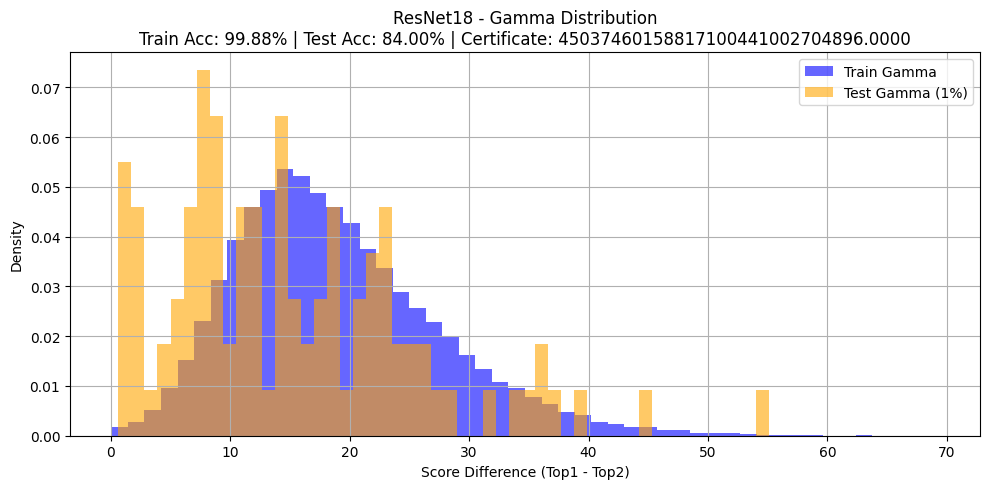

In [52]:
cert_value = certificate(sample_size=len(test_subset), gamma=true_gamma, model=model)

plt.figure(figsize=(10, 5))
plt.hist(train_diffs, bins=50, alpha=0.6, label="Train Gamma", color="blue", density=True)
plt.hist(test_diffs, bins=50, alpha=0.6, label="Test Gamma (1%)", color="orange", density=True)
plt.xlabel("Score Difference (Top1 - Top2)")
plt.ylabel("Density")
plt.title(f"ResNet18 - Gamma Distribution\nTrain Acc: {train_acc:.2%} | Test Acc: {test_acc:.2%} | Certificate: {cert_value:.4f}")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("gamma_hist_ResNet18.png")
plt.show()


In [44]:
print((train_diffs))

[np.float32(14.659958), np.float32(28.406292), np.float32(16.684328), np.float32(28.79659), np.float32(38.091442), np.float32(18.871462), np.float32(31.369099), np.float32(34.953007), np.float32(17.750809), np.float32(16.645359), np.float32(20.389214), np.float32(18.953428), np.float32(24.069801), np.float32(22.560665), np.float32(10.001975), np.float32(20.448704), np.float32(15.879065), np.float32(9.075275), np.float32(9.469559), np.float32(22.70966), np.float32(19.663357), np.float32(11.245841), np.float32(27.755964), np.float32(22.713638), np.float32(18.94876), np.float32(13.643735), np.float32(25.041597), np.float32(11.592262), np.float32(16.935478), np.float32(11.994284), np.float32(16.606522), np.float32(12.796442), np.float32(39.502476), np.float32(14.293511), np.float32(18.771177), np.float32(23.191216), np.float32(14.711739), np.float32(22.955091), np.float32(14.319916), np.float32(12.24411), np.float32(5.456522), np.float32(26.873283), np.float32(33.294174), np.float32(36.391